In [1]:
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io
%matplotlib inline

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
        

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_output=4):
        super(ResNet,self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        #self.linear = nn.Linear(512*block.expansion, num_output) 
        self.linear = nn.Linear(153600, num_output)     

        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
class DroNet(nn.Module):
    def __init__(self,block,num_output=4):
        super(DroNet,self).__init__()
        self.in_planes = 32
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=5, stride=2, padding=1, bias=False)
        self.pool = nn.MaxPool2d(3,stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block,32,stride=2)
        self.layer2 = self._make_layer(block,64,stride=2)
        self.layer3 = self._make_layer(block,128,stride=2)
        self.linear = nn.Linear(1920, num_output)
        
    def _make_layer(self, block, planes, stride=2):
        layer = block(self.in_planes, planes, stride)
        self.in_planes = planes*block.expansion

        return nn.Sequential(layer)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [5]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])
def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = image.resize((320,240))
    return image
transform = transforms.ToTensor()

In [6]:
image = Image.open('./gate_img/3000.jpg')
image = image.resize((320,240))

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
start_epoch = 0
#net = ResNet18().to(device)
net = DroNet(BasicBlock).to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [8]:
class GateDataset(Dataset):
    def __init__(self, txt, transform, loader,train=True):
        f=open(txt, 'r')
        data = []
        count = 0
        for line in f:
            line = line.strip('\n')
            line = line.rstrip()
            words = line.split()
            label = np.array([float(words[1]),float(words[2]),float(words[3]),float(words[4])])
            label = torch.from_numpy(label)
            if train:
                if (count%1==0)&(count <= 2500):
                    data.append((words[0],label))
                count+=1
            else:
                if (count%1==0)&(count > 2500):
                    data.append((words[0],label))
                count+=1
        self.data = data
        self.transform = transform
        self.loader = loader
        
    
    def __getitem__(self, index):
        img_file, label = self.data[index]
        img_file = './gate_img/'+img_file
        img = self.loader(img_file)
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.data)   

In [9]:
train_data = GateDataset(txt='./gate_img/ground_truth.txt',transform=transforms.ToTensor(),loader=image_loader,train=True)
test_data = GateDataset(txt='./gate_img/ground_truth.txt',transform=transforms.ToTensor(),loader=image_loader,train=False)
data_loader = DataLoader(train_data, batch_size=200,shuffle=True)
data_loader_test = DataLoader(test_data, batch_size=200,shuffle=False)


In [10]:
print(len(data_loader))
images, labels = next(iter(data_loader))
print(images.size())

13
torch.Size([200, 3, 240, 320])


In [11]:
global in_planes
in_planes = 32
def _make_layer(block, planes, stride=2):
    global in_planes
    layer = block(in_planes, planes, stride)
    in_planes = planes*block.expansion
    return nn.Sequential(layer)

print(len(data_loader))
images, labels = next(iter(data_loader))
print(images.size())
conv1 = nn.Conv2d(3,32,kernel_size=5, stride=2, padding=2, bias=False)
bn1 = nn.BatchNorm2d(32)
out = F.relu(bn1(conv1(images)))
layer1 = _make_layer(BasicBlock,32,stride=2)
print(out.size())
out = layer1(out)
print(out.size())
layer2 = _make_layer(BasicBlock,64,stride=2)
out = layer2(out)
print(out.size())
layer3 = _make_layer(BasicBlock,128,stride=2)
out = layer3(out)
print(out.size())
out = F.avg_pool2d(out, 4)
print(out.size())
out = out.view(out.size(0), -1)
print(out.size())
linear = nn.Linear(1920, 4)
out = linear(out)
print(out.size())






13
torch.Size([200, 3, 240, 320])
torch.Size([200, 32, 120, 160])
torch.Size([200, 32, 60, 80])
torch.Size([200, 64, 30, 40])
torch.Size([200, 128, 15, 20])
torch.Size([200, 128, 3, 5])
torch.Size([200, 1920])
torch.Size([200, 4])


In [12]:
num_block = [2,2,2,2]
global in_planes
in_planes = 64
def _make_layer(block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    global in_planes
    for stride in strides:
        layers.append(block(in_planes, planes, stride))
        in_planes = planes * block.expansion
    return nn.Sequential(*layers)



print(len(data_loader))
#images, labels = next(iter(data_loader))
images = torch.randn(2,3,240,320)
print(images.size())
conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
bn1 = nn.BatchNorm2d(64)
out = F.relu(bn1(conv1(images)))
layer1 = _make_layer(BasicBlock,64,num_block[0],stride=1)

out = layer1(out)
print(out.size())
layer2 = _make_layer(BasicBlock,128,num_block[1],stride=2)
out = layer2(out)
print(out.size())
layer3 = _make_layer(BasicBlock,256,num_block[2],stride=2)
out = layer3(out)
print(out.size())
layer4 = _make_layer(BasicBlock,512,num_block[3],stride=2)
out = layer4(out)
print(out.size())
out = F.avg_pool2d(out, 4)
print(out.size())
out = out.view(out.size(0), -1)
print(out.size())
linear = nn.Linear(35840, 4)
out = linear(out)
print(out.size())

13
torch.Size([2, 3, 240, 320])
torch.Size([2, 64, 240, 320])
torch.Size([2, 128, 120, 160])
torch.Size([2, 256, 60, 80])
torch.Size([2, 512, 30, 40])
torch.Size([2, 512, 7, 10])
torch.Size([2, 35840])
torch.Size([2, 4])


In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 150], gamma=0.1, last_epoch=-1)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
#criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()

In [14]:
def train(epoch, net):
    #print('\nEpoch: {} ==> lr: {}'.format(epoch, scheduler.get_last_lr()))
    net.train()
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        targets = torch.tensor(targets, dtype=torch.float32).to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loss = (train_loss/(batch_idx+1))
        print("the trainning loss is (%-10.3f): " %(train_loss))
def test(epoch, net):
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader_test):
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            targets = torch.tensor(targets, dtype=torch.float32).to(device)
            outputs = net(inputs) 
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            test_loss = test_loss/(batch_idx+1)
            print("the test loss is (%-10.3f): " %(test_loss))



            
        

In [15]:
print('==> Training parameters:')
print('        start_epoch = {}'.format(start_epoch+1))
print('        lr @epoch=0 = {}'.format(0.1))
print('==> Starting training...')
for epoch in range(0, 15):
    if epoch>start_epoch:
        train(epoch, net)
        test(epoch, net)
    scheduler.step()

==> Training parameters:
        start_epoch = 1
        lr @epoch=0 = 0.1
==> Starting training...


/home/colin/anaconda3/envs/deep_uncertainty/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/colin/anaconda3/envs/deep_uncertainty/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/colin/anaconda3/envs/deep_uncertainty/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy co

the trainning loss is (24.104    ): 
the trainning loss is (14.510    ): 
the trainning loss is (10.246    ): 
the trainning loss is (4.348     ): 
the trainning loss is (1.279     ): 
the trainning loss is (0.817     ): 
the trainning loss is (0.719     ): 
the trainning loss is (0.335     ): 
the trainning loss is (0.267     ): 
the trainning loss is (0.320     ): 
the trainning loss is (0.180     ): 
the trainning loss is (0.157     ): 
the trainning loss is (0.159     ): 


/home/colin/anaconda3/envs/deep_uncertainty/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/colin/anaconda3/envs/deep_uncertainty/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


the test loss is (11.463    ): 
the test loss is (9.377     ): 
the test loss is (3.446     ): 
the test loss is (3.286     ): 
the trainning loss is (1.422     ): 
the trainning loss is (1.340     ): 
the trainning loss is (0.861     ): 
the trainning loss is (0.469     ): 
the trainning loss is (0.291     ): 
the trainning loss is (0.215     ): 
the trainning loss is (0.150     ): 
the trainning loss is (0.119     ): 
the trainning loss is (0.092     ): 
the trainning loss is (0.074     ): 
the trainning loss is (0.058     ): 
the trainning loss is (0.052     ): 
the trainning loss is (0.046     ): 
the test loss is (2.161     ): 
the test loss is (2.107     ): 
the test loss is (2.048     ): 
the test loss is (1.077     ): 
the trainning loss is (0.498     ): 
the trainning loss is (0.441     ): 
the trainning loss is (0.293     ): 
the trainning loss is (0.162     ): 
the trainning loss is (0.121     ): 
the trainning loss is (0.068     ): 
the trainning loss is (0.047     ): 
the 

tensor([[1.0057, 0.1423, 1.7541, 0.0117]], device='cuda:0',
       grad_fn=<AddmmBackward>)

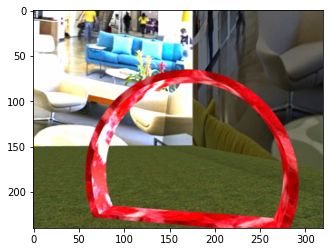

In [21]:
image = Image.open('./gate_img/3031.jpg')
image = image.resize((320,240))
plt.imshow(image)
image_tensor = transform(image)
image_tensor = image_tensor.view(1,3,240,320)
output = net(image_tensor)
output